In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [13]:
# Load dataset
df = pd.read_csv("HousingData.csv")

In [14]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [15]:
df.isnull().sum()

,0
CRIM,20
ZN,20
INDUS,20
CHAS,20
NOX,0
RM,0
AGE,20
DIS,0
RAD,0
TAX,0


In [16]:
# Drop rows with NaNs
df = df.dropna()


In [17]:
df.isnull().sum()

,0
CRIM,0
ZN,0
INDUS,0
CHAS,0
NOX,0
RM,0
AGE,0
DIS,0
RAD,0
TAX,0


In [18]:
# Separate features and target
X = df.drop("MEDV", axis=1)
y = df["MEDV"].values


In [21]:
# Separate features and target
X = df.drop("MEDV", axis=1)
y = df["MEDV"].values

# Normalize numerical features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=df.drop("MEDV", axis=1).columns)

In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)


In [23]:
# Linear Regression from scratch
class LinearRegressionScratch:
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        self.bias = theta_best[0]
        self.weights = theta_best[1:]

    def predict(self, X):
        return X.dot(self.weights) + self.bias

In [24]:
# Decision Tree class
class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.mean = None
        self.used_features = []

    def fit(self, X, y):
        self.mean = np.mean(y)
        self.used_features = list(np.random.choice(X.shape[1], min(3, X.shape[1]), replace=False))

    def predict(self, X):
        return np.full(X.shape[0], self.mean)

In [25]:
# Random Forest from scratch
class RandomForestScratch:
    def __init__(self, n_trees=10, max_depth=5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            idxs = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[idxs], y[idxs]
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

In [26]:
# Simplified XGBoost
class XGBoostScratch:
    def __init__(self, n_trees=10):
        self.n_trees = n_trees
        self.trees = []

    def fit(self, X, y):
        pred = np.zeros(len(y))
        for _ in range(self.n_trees):
            residuals = y - pred
            tree = DecisionTree(max_depth=3)
            tree.fit(X, residuals)
            update = tree.predict(X)
            pred += update
            self.trees.append(tree)

    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for tree in self.trees:
            pred += tree.predict(X)
        return pred


In [27]:
# Evaluation function
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return rmse, r2


In [28]:
# Feature importance calculation
def get_feature_importance(model, feature_names):
    importance = np.zeros(len(feature_names))
    for tree in model.trees:
        for idx in tree.used_features:
            importance[idx] += 1
    total = importance.sum()
    if total == 0:
        return np.zeros(len(feature_names))
    return importance / total

In [29]:
# Plot feature importance
def plot_feature_importance(importances, feature_names):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [30]:
# Train and evaluate models
models = {
    "Linear Regression": LinearRegressionScratch(),
    "Random Forest": RandomForestScratch(n_trees=10, max_depth=5),
    "XGBoost": XGBoostScratch(n_trees=10)
}

In [31]:
for name, model in models.items():
    model.fit(X_train, y_train)
    rmse, r2 = evaluate(model, X_test, y_test)
    print(f"{name} -> RMSE: {rmse:.2f}, R²: {r2:.2f}")

Linear Regression -> RMSE: 5.61, R²: 0.63
Random Forest -> RMSE: 9.40, R²: -0.05
XGBoost -> RMSE: 9.36, R²: -0.04



Random Forest Feature Importances:


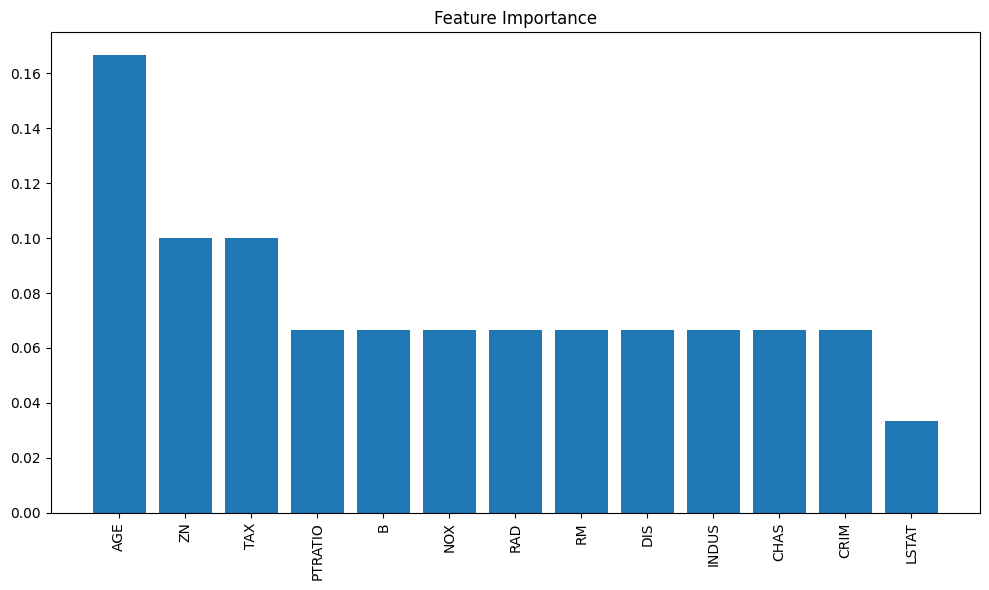


XGBoost Feature Importances:


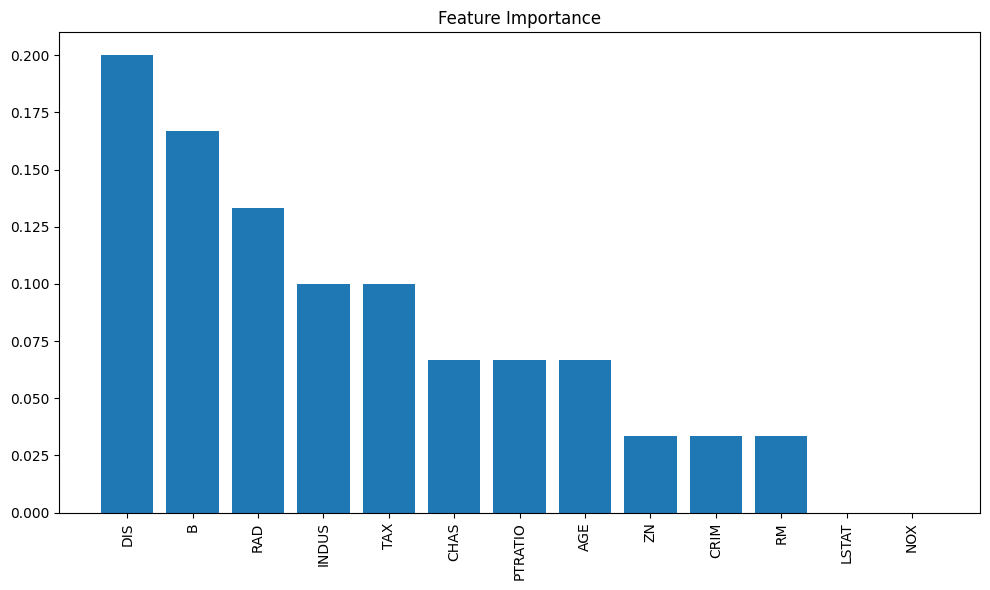

In [32]:
# Plot feature importance for Random Forest and XGBoost
feature_names = X.columns
for name in ["Random Forest", "XGBoost"]:
    importances = get_feature_importance(models[name], feature_names)
    print(f"\n{name} Feature Importances:")
    plot_feature_importance(importances, feature_names)